In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import gelman_rubin, effective_sample_size as numpyro_ess
from numpyro.distributions import constraints
from numpyro.distributions.transforms import biject_to, IdentityTransform

In [2]:
from noise_sampler_fixed_fc import flicker_cov, flicker_logdet, flicker_cov_jax, flicker_logdet_jax


Using the emulator for flicker noise correlation function.
Get the JAX version of the emulators
Get the JAX version of the log-det emulator


In [3]:
import jax
import jax.numpy as jnp
from nuts_sampler import NUTS_sampler, make_transforms, unconstrained_to_constrained


In [4]:

# 2D target: theta ~ N(mu, diag(sigmas^2)), with bounds on the 2nd dim: (1, 3)
mu = jnp.array([-1.0, 2.0])
sigmas = jnp.array([0.5, 0.5])
inv_cov = jnp.diag(1.0 / (sigmas**2))  # precision matrix

def loglik(theta, mu, inv_cov):
    theta = jnp.atleast_1d(theta)
    delta = theta - mu
    return -0.5 * delta @ inv_cov @ delta  # scalar

bounds = [(None, None), (1.0, 3.0)]  # unbounded first dim, interval for second
event_shape = (2,)

# Run NUTS (uniform prior over bounds -> use prior_type=None; transforms enforce support)
mcmc, theta_samples = NUTS_sampler(
    log_likeli_fn=loglik,
    init_params=mu,                    # must be strictly within open intervals
    log_likeli_args=(mu, inv_cov),
    event_shape=event_shape,
    bounds=bounds,
    prior_type=None,                   # uniform over bounds (no extra log prior)
    N_chains=2,
    initial_warmup=8000,
    max_warmup=8000,
    N_samples=2000,
    rng_key=jax.random.PRNGKey(0),
)

# Map z-samples back to constrained theta
# z = samples  # shape: (chains, samples, D) in unconstrained space
# z_flat = z.reshape(-1, z.shape[-1])
# tfms = make_transforms(bounds, dim=2)

# def map_batch(z_batch):
#     thetas = []
#     for zi in z_batch:
#         theta_i, _ = unconstrained_to_constrained(zi, tfms)
#         thetas.append(theta_i)
#     return jnp.stack(thetas)

# theta_samples = map_batch(z_flat)  # shape: (chains*samples, D)

# Basic checks
theta_mean = theta_samples.mean(axis=0)
theta_std = theta_samples.std(axis=0)

print("True mu:", mu)
print("Sample mean:", theta_mean)
print("True stds:", sigmas)
print("Sample stds:", theta_std)
print("Alpha bounds check (should be strictly within (1,3)):")
print("min =", float(theta_samples[:, 1].min()), "max =", float(theta_samples[:, 1].max()))

# Assert expectations (tolerances loose to avoid flakiness)
assert abs(theta_mean[0] - mu[0]) < 0.05
assert abs(theta_mean[1] - mu[1]) < 0.03
assert (theta_samples[:, 1] > 1.0).all() and (theta_samples[:, 1] < 3.0).all()
print("OK: means close to truth and bounds respected.")

Running warmup round: 8000 additional steps (total warmup: 8000)


/Users/zzhang/Workspace/flicker/hydra_tod/nuts_sampler.py:198: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=current_warmup, num_samples=N_samples, num_chains=N_chains, progress_bar=False)


Max R-hat: 0.9998 (after 8000 total warmup steps)
✅ Convergence achieved with 8000 total warmup steps!
True mu: [-1.  2.]
Sample mean: [-1.0103261  1.9885422]
True stds: [0.5 0.5]
Sample stds: [0.48760146 0.44051608]
Alpha bounds check (should be strictly within (1,3)):
min = 1.000128984451294 max = 2.9910945892333984
OK: means close to truth and bounds respected.


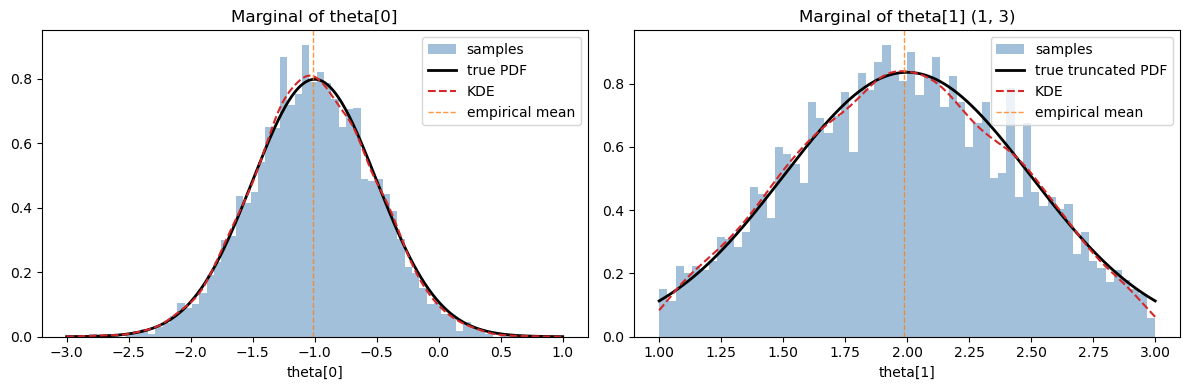

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm, gaussian_kde

# Convert to numpy
x = np.array(theta_samples[:, 0])
y = np.array(theta_samples[:, 1])

mu0, mu1 = float(mu[0]), float(mu[1])
sig0, sig1 = float(sigmas[0]), float(sigmas[1])

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# X marginal (unbounded Normal)
x_grid = np.linspace(mu0 - 4*sig0, mu0 + 4*sig0, 400)
pdf_x = norm.pdf(x_grid, loc=mu0, scale=sig0)
ax[0].hist(x, bins=60, density=True, alpha=0.5, color="steelblue", label="samples")
ax[0].plot(x_grid, pdf_x, "k-", lw=2, label="true PDF")
# Empirical KDE
kde_x = gaussian_kde(x)
ax[0].plot(x_grid, kde_x(x_grid), "C3--", lw=1.5, label="KDE")
ax[0].axvline(x.mean(), color="C1", ls="--", lw=1, alpha=0.8, label="empirical mean")
ax[0].set_title("Marginal of theta[0]")
ax[0].set_xlabel("theta[0]")
ax[0].legend()

# Y marginal (truncated Normal on (1, 3))
a, b = (1.0 - mu1)/sig1, (3.0 - mu1)/sig1
y_grid = np.linspace(1.0, 3.0, 400)
pdf_y = truncnorm.pdf(y_grid, a, b, loc=mu1, scale=sig1)
ax[1].hist(y, bins=60, range=(1.0, 3.0), density=True, alpha=0.5, color="steelblue", label="samples")
ax[1].plot(y_grid, pdf_y, "k-", lw=2, label="true truncated PDF")
# Empirical KDE (note: KDE ignores hard bounds and can leak slightly)
kde_y = gaussian_kde(y)
ax[1].plot(y_grid, kde_y(y_grid), "C3--", lw=1.5, label="KDE")
ax[1].axvline(y.mean(), color="C1", ls="--", lw=1, alpha=0.8, label="empirical mean")
ax[1].set_title("Marginal of theta[1] (1, 3)")
ax[1].set_xlabel("theta[1]")
ax[1].legend()

plt.tight_layout()
plt.show()

## Test flicker sampler likelihood

In [4]:
import numpy as np


In [5]:
def heat_maps(X, Y, Z1, Z2):
    # -------------------------
    fig, ax = plt.subplots(2, 1, figsize=(6, 10))
    ax = ax.flatten()

    # Filled heatmap (smooth color shading)
    # cmap = plt.cm.viridis
    cmap = plt.cm.coolwarm
    heat = ax[0].contourf(X, Y, Z1, levels=50, cmap=cmap)

    # Contour lines (iso-values)
    contours = ax[0].contour(X, Y, Z1, levels=10, colors='black', linewidths=0.8)
    ax[0].clabel(contours, inline=True, fontsize=10, fmt="%.0f")

    # Colorbar
    cbar = fig.colorbar(heat, ax=ax[0])
    # cbar.set_label("Function value", fontsize=12)


    # Axis labels and style
    # ax[0].set_xlabel(r"$a$ (cm)", fontsize=13)
    # ax[0].set_ylabel(r"$\beta$", fontsize=13)
    # ax[0].set_title(fr"$\nu_p(a, \beta)$  [GHz]", fontsize=14)
    ax[0].tick_params(labelsize=10)

    cmap = plt.cm.coolwarm
    heat = ax[1].contourf(X, Y, Z2, levels=50, cmap=cmap)
    contours = ax[1].contour(X, Y, Z2, levels=10, colors='black', linewidths=0.8)
    # ax[1].clabel(contours, inline=True, fontsize=10, fmt="%.2f",
    #             rightside_up=True, inline_spacing=15)

    levels_to_label = contours.levels[1:-1] if len(contours.levels) > 2 else contours.levels
    ax[1].clabel(contours, levels=levels_to_label, inline=True, fontsize=10, fmt="%.3f",
                rightside_up=True, inline_spacing=15)


    cbar = fig.colorbar(heat, ax=ax[1], format="%.3f")
    # ax[1].set_xlabel(r"$a$ (cm)", fontsize=13)
    # ax[1].set_ylabel(r"$\beta$", fontsize=13)
    # ax[1].set_title(fr"$W(a, \beta)$", fontsize=14)
    ax[1].tick_params(labelsize=10)

    fig.tight_layout()

    plt.show()

In [6]:
# Load the simulation results
import pickle
from simulation import TODSimulation

with open('../test/tod_simulation_single.pkl', 'rb') as f:
    tod_sim = pickle.load(f)


In [7]:
data = tod_sim.TOD_setting
gain = tod_sim.gains_setting
Tsys = tod_sim.Tsys_setting

flicker_bounds = [[-6.0, -3.0], [1.1, 4.0]] 

In [75]:
from noise_sampler_fixed_fc import flicker_log_post_JAX


log_post_constr_uni = flicker_log_post_JAX(data, gain, Tsys, 
                                include_DC_Gain=False, 
                                prior_func=None, 
                                jeffreys=False, 
                                bounds=None)

def log_prior_noise(params):
    _, alpha_est = params
    return -1e10 * (alpha_est - 2.0)**4 

log_post_constr_prior = flicker_log_post_JAX(data, gain, Tsys, 
                                include_DC_Gain=False, 
                                prior_func=log_prior_noise, 
                                jeffreys=False, 
                                bounds=None)

log_post_constr_jeff = flicker_log_post_JAX(data, gain, Tsys, 
                                include_DC_Gain=False, 
                                prior_func=None, 
                                jeffreys=True, 
                                bounds=None)

# tfms = make_transforms(flicker_bounds, 2)

log_post_unconstr_uni = flicker_log_post_JAX(data, gain, Tsys, 
                                include_DC_Gain=False, 
                                prior_func=None, 
                                jeffreys=False, 
                                bounds=flicker_bounds)

log_post_unconstr_jeff = flicker_log_post_JAX(data, gain, Tsys, 
                                include_DC_Gain=False, 
                                prior_func=None, 
                                jeffreys=True, 
                                bounds=flicker_bounds)

In [131]:
logf0_tab = np.linspace(-6,-3,20)
alpha_tab = np.linspace(1.1,4,20)

X, Y = np.meshgrid(logf0_tab, alpha_tab)

max log prob: 16961.418 at logf0 = 4.894736842105264


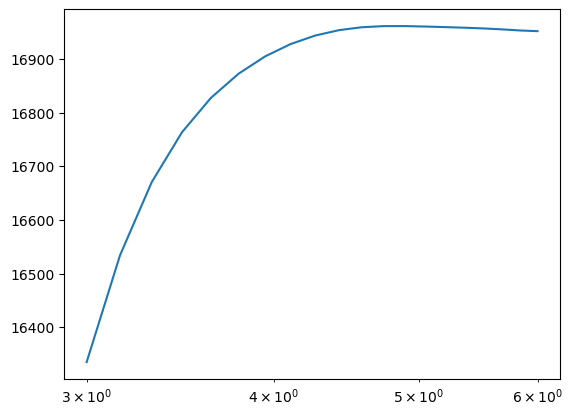

In [77]:
log_probs = [log_post_constr_prior([item,2.0]) for item in logf0_tab]
plt.plot(-logf0_tab, log_probs)
# plt.yscale('log')
plt.xscale('log')

# find the maximum log probability
max_log_prob = np.max(log_probs)
max_log_prob_idx = np.argmax(log_probs)
print("max log prob:", max_log_prob, "at logf0 =", -logf0_tab[max_log_prob_idx])

In [78]:
from tqdm import tqdm

Z_c_u = np.zeros_like(X)
for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[1]):
        Z_c_u[i, j] = log_post_constr_uni([X[i, j], Y[i, j]])


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


In [79]:
# find the indice of the maximum in the 2D array Z_c_u
max_index = jnp.argmax(Z_c_u)
X_max = X.flatten()[max_index]
Y_max = Y.flatten()[max_index]
print("max log prob (constr, uni):", float(Z_c_u.max()), "at logf0 =", float(X_max), ", alpha =", float(Y_max)) 

max log prob (constr, uni): 16963.6015625 at logf0 = -5.2105263157894735 , alpha = 1.710526315789474


In [80]:
Z_c_p = np.zeros_like(X)
for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[1]):
        Z_c_p[i, j] = log_post_constr_prior(jnp.array([X[i, j], Y[i, j]]))

100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


In [81]:
Z_c_j = np.zeros_like(X)
for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[1]):
        Z_c_j[i, j] = log_post_constr_jeff(jnp.array([X[i, j], Y[i, j]]))

100%|██████████| 20/20 [01:05<00:00,  3.26s/it]


max log prob (constr, uni): 16963.6015625 at logf0 = -5.2105263157894735 , alpha = 1.710526315789474


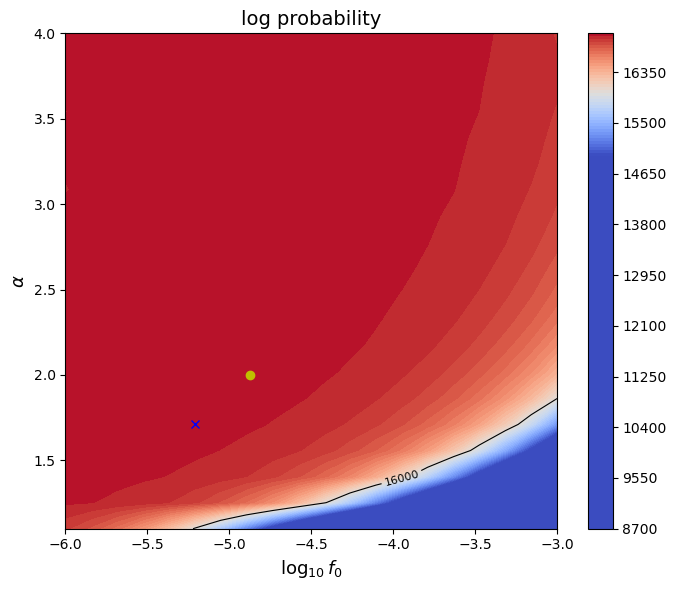

In [83]:
heat_map(X, Y, Z_c_u, vmin=np.max(Z_c_u)-2000)

max log prob (constr, uni): 16963.6015625 at logf0 = -5.2105263157894735 , alpha = 1.710526315789474


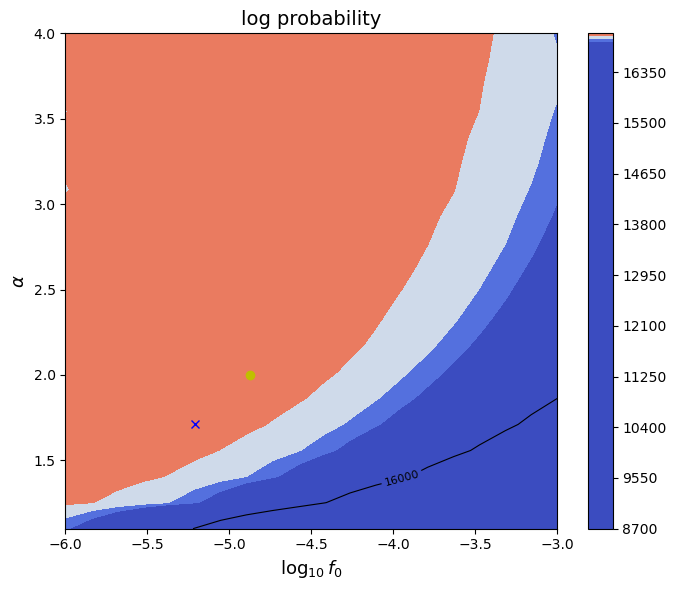

In [91]:
heat_map(X, Y, Z_c_u, vmin=np.max(Z_c_u)-100)

### Sampler

In [32]:
from noise_sampler_fixed_fc import flicker_sampler

In [36]:
# noise_sample = flicker_sampler(
#                 data,
#                 gain,
#                 Tsys,
#                 init_params=jnp.array([-4.8, 2.0]), # using the input init_noise_params as fixed initial point for MCMC sampling
#                 n_samples=1000,
#                 include_DC_Gain=False, 
#                 prior_func=None,
#                 jeffreys=False,
#                 bounds=[(-6, -3),(1.1, 4.0)],
#                 sampler="emcee",
#                 rng_key=42
#             )

## Asymptotic unbiasedness

In [72]:
from flicker_model import sim_noise, flicker_cov
from noise_sampler_fixed_fc import log_likeli

# Define the likelihood function for the flicker noise model.
def flicker_log_likeli_func(dvec, time_list, wnoise_var=2.5e-6):
    '''
    Note that f0 and fc are in unit of angular frequency, differently from that of FFT frequencies by a factor of 2pi.
    '''
    # corr_list = flicker_cov(tau_list, f0, fc, alpha,  white_n_variance=wnoise_var, only_row_0=True)

    def log_like(params):
        logf0, alpha = params
        corr_list = flicker_cov(time_list, 10.**logf0, tod_sim.fc, alpha, 
                                white_n_variance=wnoise_var, only_row_0=True)
        return log_likeli(corr_list, dvec)
    
    return log_like

def func(num):
    from tqdm import tqdm
    
    time_list = np.arange(num) * 2.0
    noise = sim_noise(tod_sim.f0, tod_sim.fc, tod_sim.alpha, time_list, n_samples=1, white_n_variance=2.5e-6)

    log_li = flicker_log_likeli_func(noise, time_list)

    Z = np.zeros_like(X)
    for i in tqdm(range(X.shape[0])):
        for j in range(X.shape[1]):
            Z[i, j] = log_li([X[i, j], Y[i, j]])

    return Z


In [92]:
Z_3000 = func(3000)

100%|██████████| 20/20 [03:39<00:00, 10.95s/it]


In [24]:
Z_3000_2 = func(3000)

100%|██████████| 15/15 [02:06<00:00,  8.42s/it]


In [25]:
Z_3000_3 = func(3000)

100%|██████████| 15/15 [02:06<00:00,  8.46s/it]


In [26]:
Z_2000 = func(2000)

100%|██████████| 15/15 [01:18<00:00,  5.25s/it]


In [27]:
Z_5000 = func(5000)
Z_8000 = func(8000)
Z_10000 = func(10000)

100%|██████████| 15/15 [10:25<00:00, 41.71s/it]


In [133]:
import matplotlib.pyplot as plt


def heat_map(X, Y, Z, vmin=None):
    # -------------------------
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # find the indice of the maximum in the 2D array Z_c_u
    max_index = jnp.argmax(Z)
    X_max = X.flatten()[max_index]
    Y_max = Y.flatten()[max_index]
    print("max log prob (constr, uni):", float(Z.max()), "at logf0 =", float(X_max), ", alpha =", float(Y_max))
    # ax = plt.gca()

    # Filled heatmap (smooth color shading)
    # cmap = plt.cm.viridis
    cmap = plt.cm.coolwarm
    heat = ax.contourf(X, Y, Z, levels=200, cmap=cmap, vmin=vmin)
    # set the limit of colour bar
    if vmin is not None:
        heat.set_clim(vmin=vmin, vmax=np.max(Z))

    # Contour lines (iso-values)
    contours = ax.contour(X, Y, Z, levels=[16000, 17000, 17500, 17750, 17800, 17830], colors='black', linewidths=0.8)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")


    # Axis labels and style
    ax.set_xlabel(r"$\log_{10}f_0$", fontsize=13)
    ax.set_ylabel(r"$\alpha$", fontsize=13)
    # ax.set_title(fr"log probability", fontsize=14)
    ax.tick_params(labelsize=10)

    # Mark the maximum point
    ax.plot(X_max, Y_max, 'bx')
    ax.plot(tod_sim.logf0, tod_sim.alpha, 'yo')

    fig.tight_layout()

    plt.savefig("heatmap.pdf")

    plt.show()

# heat_map(X, Y, Z_c_u)

max log prob (constr, uni): 17842.271756848804 at logf0 = -5.526315789473684 , alpha = 1.5578947368421052


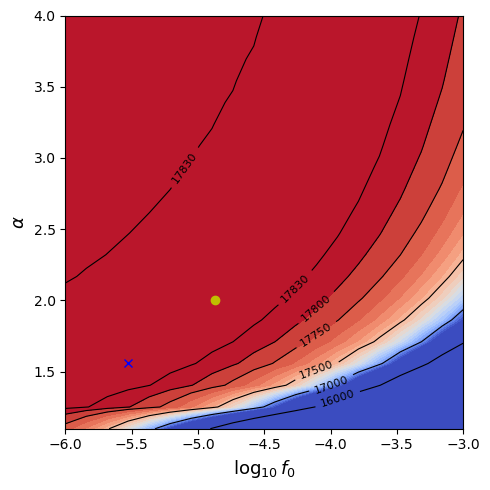

In [134]:
Z= Z_3000
heat_map(X, Y, Z, vmin=np.max(Z)-1000)

In [ ]:

def func_fix_alpha(num):
    from tqdm import tqdm
    
    time_list = np.arange(num) * 2.0
    noise = sim_noise(tod_sim.f0, tod_sim.fc, tod_sim.alpha, time_list, n_samples=1, white_n_variance=2.5e-6)

    log_li = flicker_log_likeli_func(noise, time_list)

    X = np.linspace(-6., -3., 100)
    Z = np.zeros_like(X)
    for i in tqdm(range(X.shape[0])):
            Z[i] = log_li([X[i], 2])

    return X, Z

X, Z_vals = func_fix_alpha(3000)


Max log prob: 17839.693 at logf0 = -4.909


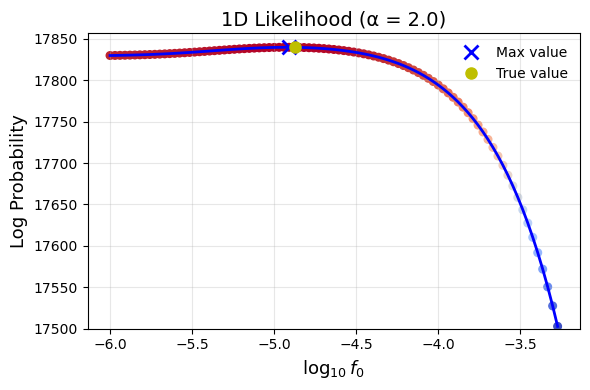

In [128]:


def plot_1d_likelihood(logf0_vals, Z_vals, vmin=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    # Find maximum
    max_idx = np.argmax(Z_vals)
    logf0_max = logf0_vals[max_idx]
    print(f"Max log prob: {float(Z_vals.max()):.3f} at logf0 = {float(logf0_max):.3f}")
    
    # Plot with color filtering
    if vmin is not None:
        # Only plot points above vmin
        mask = Z_vals >= vmin
        ax.plot(logf0_vals[mask], Z_vals[mask], 'b-', linewidth=2)
        ax.scatter(logf0_vals[mask], Z_vals[mask], c=Z_vals[mask], 
                  cmap='coolwarm', vmin=vmin, s=30)
    else:
        ax.plot(logf0_vals, Z_vals, 'b-', linewidth=2)
        ax.scatter(logf0_vals, Z_vals, c=Z_vals, cmap='coolwarm', s=30)
    
    # Mark maximum
    ax.plot(logf0_max, Z_vals[max_idx], 'bx', markersize=10, markeredgewidth=2, label='Max value')
    ax.plot(tod_sim.logf0, Z_vals[max_idx], 'yo', markersize=8, label='True value')  # True value
    ax.set_ylim(bottom=17500)

    ax.set_xlabel(r'$\log_{10}f_0$', fontsize=13)
    ax.set_ylabel('Log Probability', fontsize=13)
    ax.set_title('1D Likelihood (α = 2.0)', fontsize=14)
    ax.grid(True, alpha=0.3)

    plt.legend(frameon=False)
    
    plt.tight_layout()
    plt.savefig("1d_likelihood.pdf")
    plt.show()

plot_1d_likelihood(X, Z_vals, vmin=17500)

In [135]:
tod_sim.logf0

-4.874571109426952